Ten notebook jest **inspirowany** przykładem https://www.ahmedbesbes.com/blog/kaggle-titanic-competition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [2]:
import os
TITANIC_PATH = ""

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Atrybuty **Age**, **Cabin** oraz **Embarked** są czasami zerowe (mniej niż 891 wartości bez wartości null), szczególnie w przypadku **Cabin** (77% ma wartość zerową). Zignorujemy teraz **Cabin** i skupimy się na reszcie. Atrybut **Age** ma około 19% wartości pustych, więc będziemy musieli zdecydować, co z nimi zrobić. Zastąpienie wartości null medianą wieku wydaje się uzasadnione.

Atrybuty **Name** i **Ticket** mogą mieć pewną wartość, ale będą one nieco trudne do przekształcenia w użyteczne liczby. Na razie będziemy je ignorować.

Rzućmy okiem na atrybuty liczbowe:

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

**Spójrzmy jak zależy płeć od przetrwania**

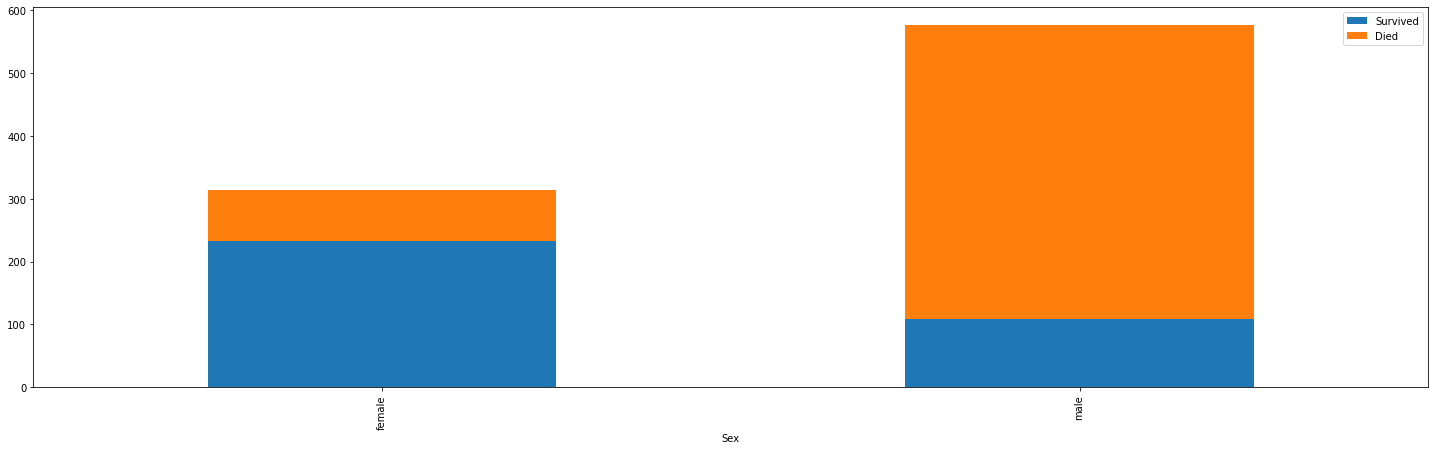

In [8]:
train_data['Died'] = 1 - train_data['Survived']
train_data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

Zróbmy **taki sam wykres** jednak tym razem z **zachowaniem proporcji**

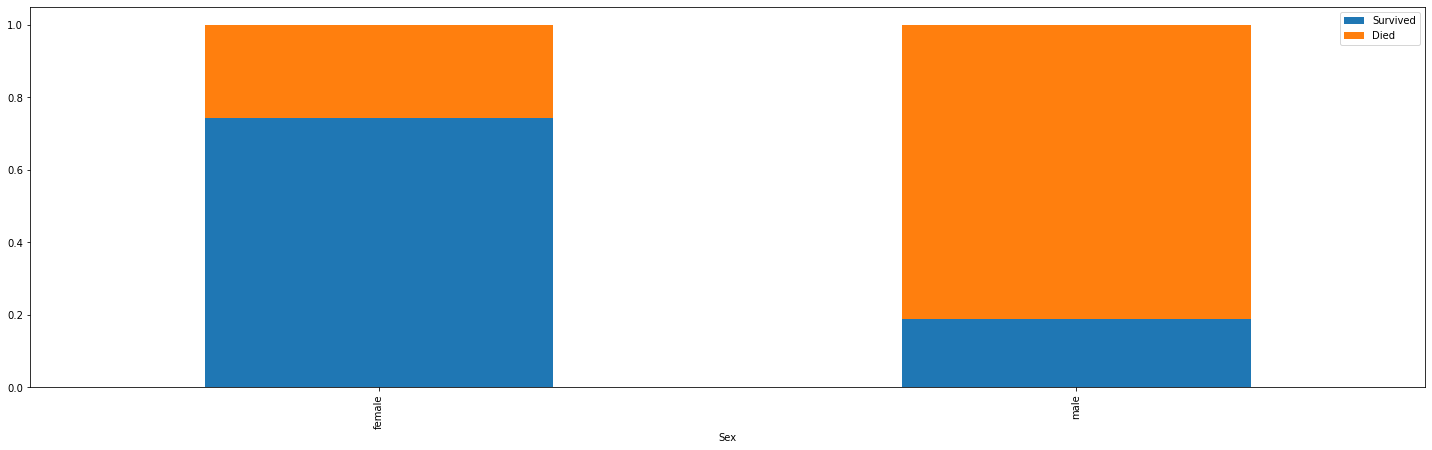

In [9]:
train_data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

Wygląda na to, że kobiety miały dużo więcej szans na przeżycie niż mężczyźni

Spójrzmy teraz jakie znaczenie miał **wiek** w kwesti **przeżycia**

*W tym celu utwórzmy wykres skrzypcowy*

<AxesSubplot:xlabel='Sex', ylabel='Age'>

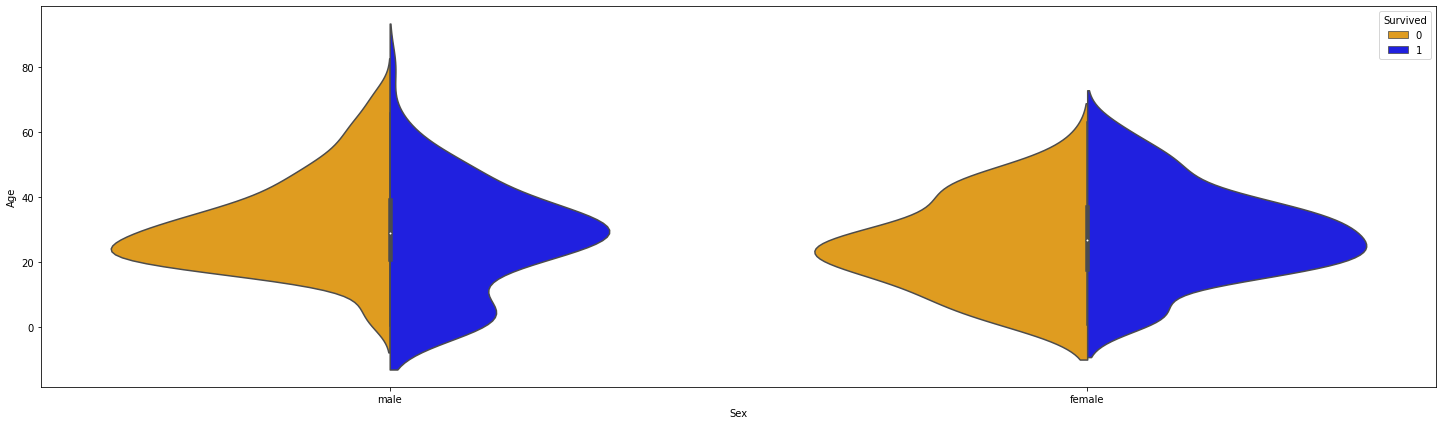

In [10]:
import seaborn as sns
fig = plt.figure(figsize=(25,7))
sns.violinplot(x='Sex', y='Age', hue='Survived',
              data = train_data, 
              split=True,
              palette={0: "orange", 1: "blue"})

Widzimy iż dla kobiet wiek nie odgrywał znaczącej roli, jednak w przypadku mężczyzn przetrwało więcej dzieci niż zginęło

# Spójrzmy teraz na cenę biletu

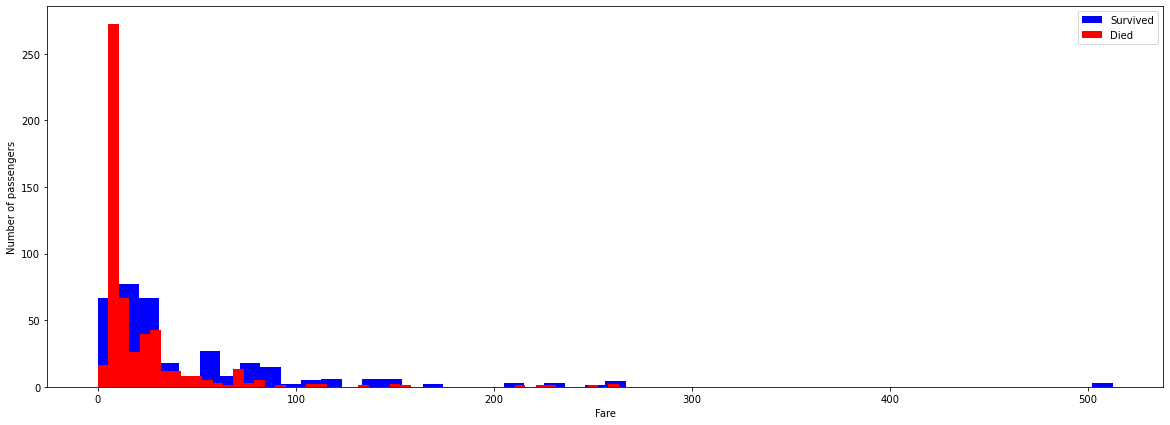

In [11]:
fig = plt.figure(figsize=(20,7))
plt.hist(train_data[train_data['Survived'] == 1]['Fare'], bins=50, color="blue", label='Survived')
plt.hist(train_data[train_data['Survived'] == 0]['Fare'], bins=50, color="red", label='Died')
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

Możemy zauważyć, iż najwięcej **zginęło** tych, którzy zakupili bilety po **najniższej cenie**

Ci, którzy **zapłacili więcej** za **bilet**, w większości **przeżyli**

*Spójrzmy teraz na cenę klas*

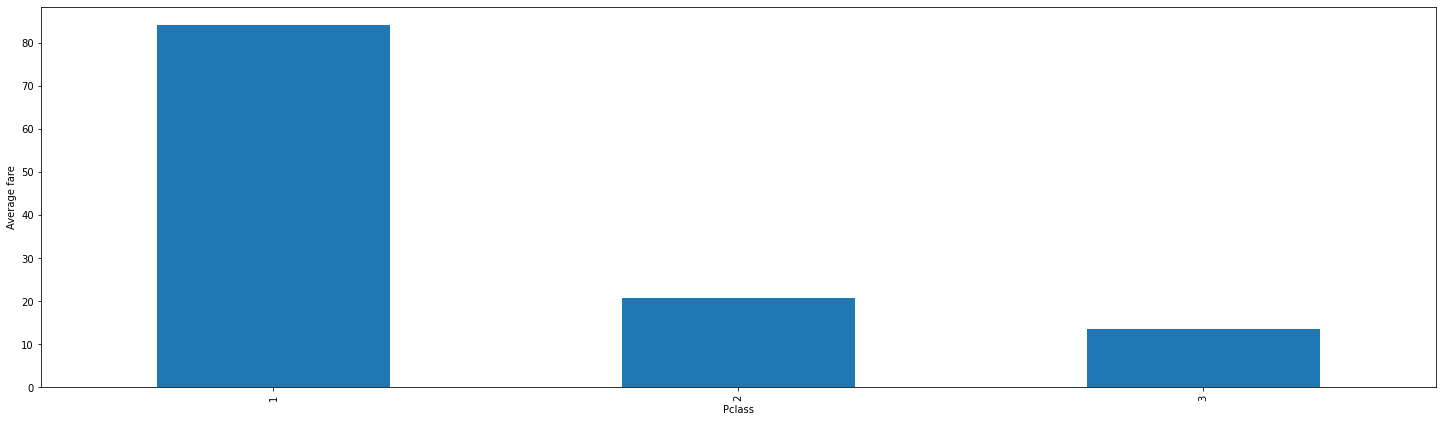

In [12]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
train_data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7));

Jak możnaby obstawiać klasa pierwsza była klasą najdroższą

**Jak jednak klasa miała się do przeżycia?**

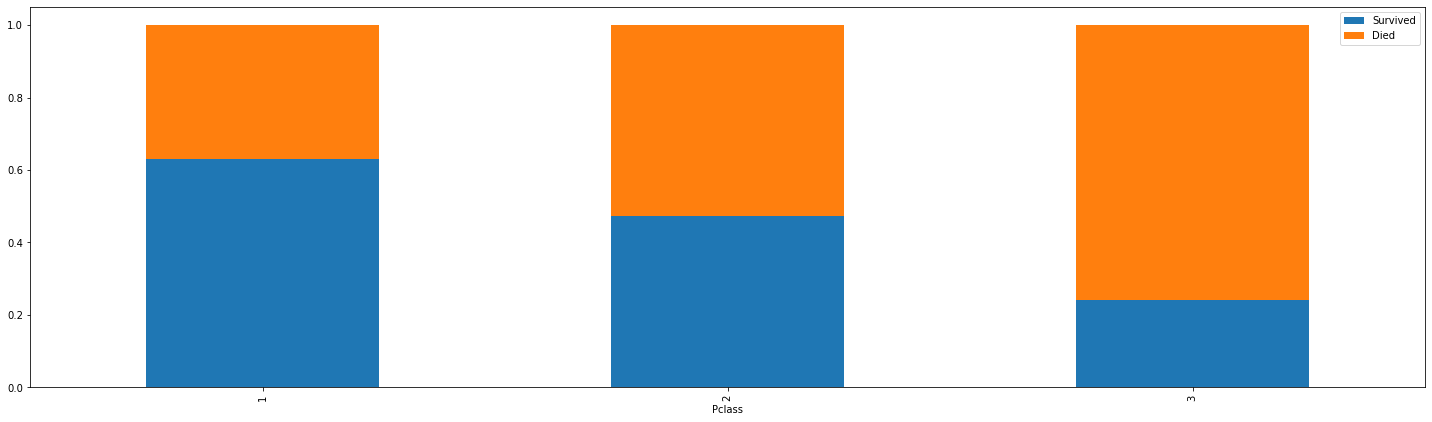

In [13]:
train_data.groupby('Pclass').mean()[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True);

* Osoby w 1 klasie miały duże szanse na przeżycie
* Osoby w 2 klasie miały około 50% szans na przeżycie
* Osoby w 3 klasie miały znikome szanse na przeżycie

Widzimy więc, iż klasy skrajne znacznie determinowały szanse na przeżycie

**Spójrzmy jeszcze czy *Emberkation*, czyli miejsce wejścia na pokład Titanica danego pasażera, miało jakiś wpływ na jego przeżycie**

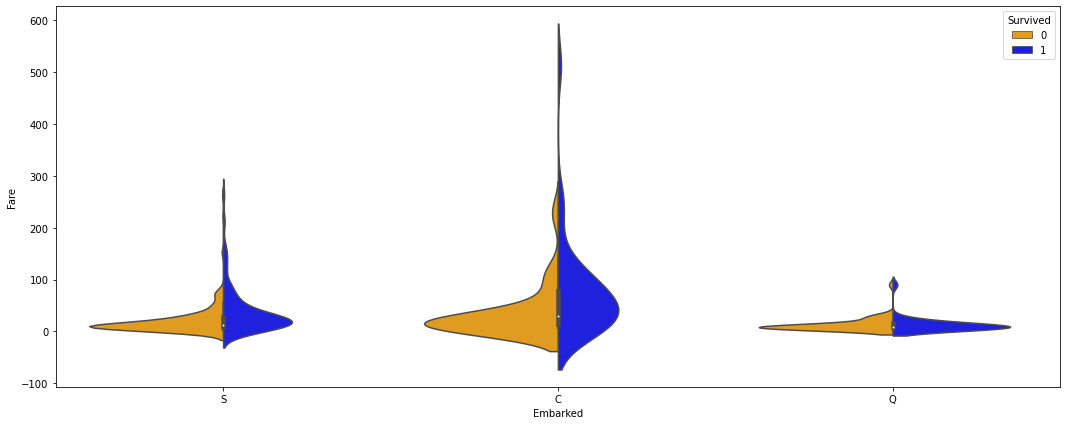

In [14]:
fig = plt.figure(figsize=(18, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', 
              data=train_data, split=True,
              palette={0: "orange", 1: "blue"});

Widzimy, iż w **C** wsiadła duża liczba osób z **drogimi biletami** i większość z nich **przetrwała**<br>
Natomiast w **Q** wykres jest niemal symetryczny więc **nie ma** tam zbytnich **zależności**<br>
**S** wygląda podobnie **do C**

# #Przetwarzanie danych

Połączymy zbiór treningowy z testowym aby miały taką samą postać<br>
**Musimy jednak pamiętać aby nie wykorzystywać informacji z test**

In [15]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [16]:
train_y = train_data["Survived"].values
train_x = train_data.drop(["Survived"], axis=1)

combined = train_x.append(test_data)
combined.reset_index(inplace=True)
combined.drop(['index','PassengerId'], inplace=True, axis=1)


combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
print(combined.shape)

(1309, 10)


**Zauważmy, że kolumna Name zawiera dodatkowe informacje takie jak:**
* Mr.
* Miss,
* Mrs.

Spróbujmy je wyciągnąć i dodać nową kolumnę o nazwie Title

In [18]:
titles = set()
for name in train_x['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
    
print(titles)


{'the Countess', 'Miss', 'Don', 'Ms', 'Jonkheer', 'Mlle', 'Lady', 'Dr', 'Mme', 'Master', 'Sir', 'Major', 'Mr', 'Rev', 'Capt', 'Col', 'Mrs'}


Posegregujmy te dane i dodajmy kolumnę Title

In [19]:
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
#doprecyzowujemy tytuł
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
combined['Title'] = combined.Title.map(Title_Dictionary)

In [20]:
combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
1307,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr


Widzimy, że przy Donie jest **NaN**, dzieje się tak ponieważ Dona nie wystąpiła w naszym zbiorze testowym

**Zajmijmy się teraz wiekiem**

In [21]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Widzimy, że w test dataset brakuje nam 177 informacji o wieku. To sporo dlatego musimy coś z tym zrobić

Moglibyśmy w te brakujące miejsca wpisać medianę wieku, jednak mogłoby to być zbyt duże uogólnienie. Spróbujmy wyznaczyć wiek na podstawie jakichś kategorii

**Spróbujmy wyznaczyć medianę na podstawie sex, Title, oraz class**

**Pamiętajmy aby korzystać tylko z train dataset!!!**

**Zbiór testowy kończy się na 890 indeksie!!**

In [22]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


Widzimy teraz jak bardzo wiek różni się w zależności od poszczególnych kategorii. Dlatego przyjęcie mediany z wieku do wypełnienia brakujących wierszów byłoby zbyt ogólne i utracilibyśmy pewne informacje

**Spróbujmy teraz uzupełnić nasze brakujące dane o wieku**

In [23]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)

In [24]:
combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Spector, Mr. Woolf",male,26.0,0,0,A.5. 3236,8.0500,NaN,S,Mr
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
1306,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
1307,3,"Ware, Mr. Frederick",male,26.0,0,0,359309,8.0500,NaN,S,Mr


In [25]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
 10  Title     1308 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 112.6+ KB


Widzimy teraz, że każdy pasażer posiada już dane o wieku

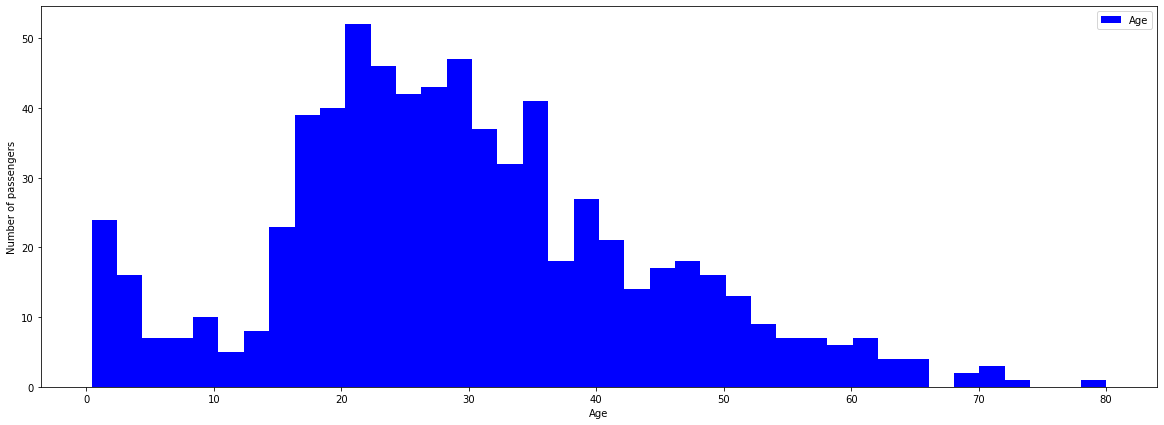

In [26]:
fig = plt.figure(figsize=(20,7))
plt.hist(train_data['Age'], bins=40, color="blue", label='Age')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

**Zobaczmy czy pogrupowanie wieku będzie miało jakiś wpływ na nasze predykcje**

In [27]:
def convertAge(age):
    if age < 10:
        return 0
    elif age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 40:
        return 3
    elif age < 50:
        return 4
    elif age < 60:
        return 5
    elif age < 70:
        return 6
    elif age < 80:
        return 7
    elif age < 90:
        return 8
    else:
        return 9


combined['AgeGroup'] = combined['Age'].map(lambda age: convertAge(age))



In [28]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,3
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,3
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,3


**Dodajmy może kolumnę determinującą czy dana osoba jest dzieckiem**

In [29]:
combined['IsChild'] = combined['Age'].map(lambda age: 1 if age<9 else 0)

In [30]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,3,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,3,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,3,0


*statystyla*

In [31]:
train_data['IsChild'] = train_data['Age'].map(lambda age: 1 if age<9 else 0)

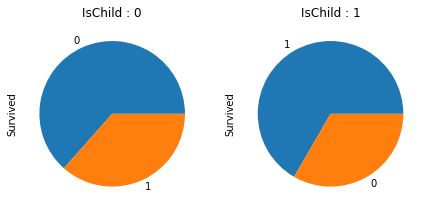

In [32]:
fig = plt.figure(figsize=(15,8))
i = 1
for child in train_data['IsChild'].unique():
    fig.add_subplot(2, 4, i)
    plt.title('IsChild : {}'.format(child))
    train_data.Survived[train_data['IsChild'] == child].value_counts().plot(kind='pie')
    i += 1

*statystyka end*

**Wykasujmy teraz kolumnę Name oraz zakodujmy kolumnę Title tak by uzyskać wartości liczbowe**

In [33]:
combined = combined.drop(["Name"], axis=1)

In [34]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,2,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,3,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,3,0


In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(combined['Title'])

LabelEncoder()

In [36]:
le.classes_

array(['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty', nan],
      dtype=object)

In [37]:
combined['Title'] = le.transform(combined['Title'])

In [38]:
combined

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,2,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,3,3,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,male,26.0,0,0,A.5. 3236,8.0500,NaN,S,2,2,0
1305,1,female,39.0,0,0,PC 17758,108.9000,C105,C,6,3,0
1306,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,2,3,0
1307,3,male,26.0,0,0,359309,8.0500,NaN,S,2,2,0


**Brakuje nam jednej wartości Fare, uzupełnijmy ją o średnią wartość Fare ze zbioru testowego**

In [39]:
combined['Fare'].fillna(combined.iloc[:891].Fare.mean(), inplace=True)

In [40]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Ticket    1309 non-null   object 
 6   Fare      1309 non-null   float64
 7   Cabin     295 non-null    object 
 8   Embarked  1307 non-null   object 
 9   Title     1309 non-null   int32  
 10  AgeGroup  1309 non-null   int64  
 11  IsChild   1309 non-null   int64  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 117.7+ KB


# **Zajmijmy się teraz missing data w Embarked**

Spróbujmy ją uzupełnić poprzez najczęściej występującą wartość Embarked w train dataset

In [41]:
embarked = combined.iloc[:891].groupby(['Embarked'])

In [42]:
embarked.count()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,AgeGroup,IsChild
Embarked,,,,,,,,,,,
C,168,168,168,168,168,168,168,69,168,168,168
Q,77,77,77,77,77,77,77,4,77,77,77
S,644,644,644,644,644,644,644,129,644,644,644


**S występuje zdecydowanie najczęściej**

In [43]:
combined.Embarked.fillna('S', inplace=True)

In [44]:
combined

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,3,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,2,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,3,3,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,male,26.0,0,0,A.5. 3236,8.0500,NaN,S,2,2,0
1305,1,female,39.0,0,0,PC 17758,108.9000,C105,C,6,3,0
1306,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,2,3,0
1307,3,male,26.0,0,0,359309,8.0500,NaN,S,2,2,0


*Kodujemy dane Embarked*

In [45]:
le = preprocessing.LabelEncoder()
le.fit(combined['Embarked'])

LabelEncoder()

In [46]:
le.classes_

array(['C', 'Q', 'S'], dtype=object)

In [47]:
combined['Embarked'] = le.transform(combined['Embarked'])

In [48]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,2,2,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,3,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,2,0
3,1,female,35.0,1,0,113803,53.1000,C123,2,3,3,0
4,3,male,35.0,0,0,373450,8.0500,NaN,2,2,3,0


# Processing Cabin

Okroimy teraz kolumnę Cabin do wartości zachowujących tylko pierwszą literkę

In [49]:
combined['Cabin'] = combined['Cabin'].map(lambda c: c if c!=c else c[0])

In [50]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,2,2,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,C,0,3,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,2,0
3,1,female,35.0,1,0,113803,53.1000,C,2,3,3,0
4,3,male,35.0,0,0,373450,8.0500,NaN,2,2,3,0


In [51]:
le = preprocessing.LabelEncoder()
le.fit(combined['Cabin'])

LabelEncoder()

In [52]:
le.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)

In [53]:
combined['Cabin'] = le.transform(combined['Cabin'])

In [54]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,male,22.0,1,0,A/5 21171,7.2500,8,2,2,2,0
1,1,female,38.0,1,0,PC 17599,71.2833,2,0,3,3,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,8,2,1,2,0
3,1,female,35.0,1,0,113803,53.1000,2,2,3,3,0
4,3,male,35.0,0,0,373450,8.0500,8,2,2,3,0


# Processing Sex

In [55]:
le = preprocessing.LabelEncoder()
le.fit(combined['Sex'])

LabelEncoder()

In [56]:
combined['Sex'] = le.transform(combined['Sex'])

In [57]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,1,22.0,1,0,A/5 21171,7.2500,8,2,2,2,0
1,1,0,38.0,1,0,PC 17599,71.2833,2,0,3,3,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,8,2,1,2,0
3,1,0,35.0,1,0,113803,53.1000,2,2,3,3,0
4,3,1,35.0,0,0,373450,8.0500,8,2,2,3,0


# Processing Ticket

Spróbujmy przerobić jakoś Ticket

Usuńmy więc znaki:      **/**     **.**

In [58]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'N/A'

tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

print(len(tickets))

37


In [59]:
print(tickets)

{'C', 'SOTONO2', 'STONO2', 'PP', 'AQ3', 'WC', 'SOPP', 'SOTONOQ', 'SCAH', 'LP', 'N/A', 'SC', 'AQ4', 'Fa', 'STONOQ', 'SCA4', 'SOP', 'SCOW', 'AS', 'FCC', 'STONO', 'SCA3', 'A', 'FC', 'PPP', 'A4', 'SCPARIS', 'LINE', 'SWPP', 'CASOTON', 'SCParis', 'WEP', 'SP', 'CA', 'SOC', 'A5', 'PC'}


Zostawiamy tylko przedrostki biletów, ich numery nas nie interesują

In [60]:
combined['Ticket'] = combined['Ticket'].map(cleanTicket)

In [61]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,1,22.0,1,0,A5,7.2500,8,2,2,2,0
1,1,0,38.0,1,0,PC,71.2833,2,0,3,3,0
2,3,0,26.0,0,0,STONO2,7.9250,8,2,1,2,0
3,1,0,35.0,1,0,N/A,53.1000,2,2,3,3,0
4,3,1,35.0,0,0,N/A,8.0500,8,2,2,3,0


*Kodujemy Ticket*

In [62]:
le = preprocessing.LabelEncoder()
le.fit(combined['Ticket'])

LabelEncoder()

In [63]:
combined['Ticket'] = le.transform(combined['Ticket'])

In [64]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0


# Processing Family

In [65]:
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

In [66]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0,2
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0,2
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0,1
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0,2
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0,1


In [67]:
combined['FamilySize'] = combined['FamilySize'].map(lambda s: 'Singleton' if s == 1 else
                                                   ('SmallFamily' if s <= 4 else 'LargeFamily'))

In [68]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0,SmallFamily
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0,SmallFamily
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0,Singleton
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0,SmallFamily
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0,Singleton


*Robimy kodowanie*

In [69]:
le = preprocessing.LabelEncoder()
le.fit(combined['FamilySize'])

LabelEncoder()

In [70]:
combined['FamilySize'] = le.transform(combined['FamilySize'])

In [71]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0,2
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0,2
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0,1
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0,2
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0,1


In [72]:
# combined.drop("SibSp", axis=1, inplace=True)  dalej to usuniemy
# combined.drop("Parch", axis=1, inplace=True)

In [73]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0,2
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0,2
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0,1
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0,2
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0,1


# Processing Fare

In [74]:
def convertFare(fare):
    if fare <= 8.05:
        return 0
    elif fare <= 14.25:
        return 1
    elif fare <= 60.2875:
        return 2
    else:
        return 3


combined['FareGroup'] = combined['Fare'].map(lambda fare: convertFare(fare))

In [75]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize,FareGroup
0,3,1,22.0,1,0,2,7.2500,8,2,2,2,0,2,0
1,1,0,38.0,1,0,15,71.2833,2,0,3,3,0,2,3
2,3,0,26.0,0,0,32,7.9250,8,2,1,2,0,1,0
3,1,0,35.0,1,0,14,53.1000,2,2,3,3,0,2,2
4,3,1,35.0,0,0,14,8.0500,8,2,2,3,0,1,0


# Skalowanie danych

Dzięki skalowaniu uzyskujemy lepszy wynik

In [76]:
from sklearn.preprocessing import StandardScaler
combined['Pclass'] = StandardScaler().fit_transform(combined['Pclass'].values.reshape(-1, 1))

In [77]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize,FareGroup
0,0.841916,1,22.0,1,0,2,7.2500,8,2,2,2,0,2,0
1,-1.546098,0,38.0,1,0,15,71.2833,2,0,3,3,0,2,3
2,0.841916,0,26.0,0,0,32,7.9250,8,2,1,2,0,1,0
3,-1.546098,0,35.0,1,0,14,53.1000,2,2,3,3,0,2,2
4,0.841916,1,35.0,0,0,14,8.0500,8,2,2,3,0,1,0


In [78]:
combined['Ticket'] = StandardScaler().fit_transform(combined['Ticket'].values.reshape(-1, 1))
combined['Fare'] = StandardScaler().fit_transform(combined['Fare'].values.reshape(-1, 1))
combined['Cabin'] = StandardScaler().fit_transform(combined['Cabin'].values.reshape(-1, 1))
combined['Embarked'] = StandardScaler().fit_transform(combined['Embarked'].values.reshape(-1, 1))
combined['Title'] = StandardScaler().fit_transform(combined['Title'].values.reshape(-1, 1))
combined['FamilySize'] = StandardScaler().fit_transform(combined['FamilySize'].values.reshape(-1, 1))
combined['AgeGroup'] = StandardScaler().fit_transform(combined['AgeGroup'].values.reshape(-1, 1))
combined['FareGroup'] = StandardScaler().fit_transform(combined['FareGroup'].values.reshape(-1, 1))
combined['SibSp'] = StandardScaler().fit_transform(combined['SibSp'].values.reshape(-1, 1))
combined['Parch'] = StandardScaler().fit_transform(combined['Parch'].values.reshape(-1, 1))

In [79]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize,FareGroup
0,0.841916,1,22.0,0.481288,-0.445,-2.360169,-0.503579,0.517788,0.622279,0.112936,-0.338008,0,1.282478,-1.240411
1,-1.546098,0,38.0,0.481288,-0.445,0.092683,0.734519,-1.927616,-1.834926,1.355233,0.375625,0,1.282478,1.563904
2,0.841916,0,26.0,-0.479087,-0.445,3.300259,-0.490527,0.517788,0.622279,-1.129361,-0.338008,0,-0.477232,-1.240411
3,-1.546098,0,35.0,0.481288,-0.445,-0.095998,0.382941,-1.927616,0.622279,1.355233,0.375625,0,1.282478,0.629132
4,0.841916,1,35.0,-0.479087,-0.445,-0.095998,-0.488110,0.517788,0.622279,0.112936,0.375625,0,-0.477232,-1.240411


In [80]:
combined['Age'] = StandardScaler().fit_transform(combined['Age'].values.reshape(-1, 1))

In [81]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,IsChild,FamilySize,FareGroup
0,0.841916,1,-0.538470,0.481288,-0.445,-2.360169,-0.503579,0.517788,0.622279,0.112936,-0.338008,0,1.282478,-1.240411
1,-1.546098,0,0.655928,0.481288,-0.445,0.092683,0.734519,-1.927616,-1.834926,1.355233,0.375625,0,1.282478,1.563904
2,0.841916,0,-0.239870,-0.479087,-0.445,3.300259,-0.490527,0.517788,0.622279,-1.129361,-0.338008,0,-0.477232,-1.240411
3,-1.546098,0,0.431979,0.481288,-0.445,-0.095998,0.382941,-1.927616,0.622279,1.355233,0.375625,0,1.282478,0.629132
4,0.841916,1,0.431979,-0.479087,-0.445,-0.095998,-0.488110,0.517788,0.622279,0.112936,0.375625,0,-0.477232,-1.240411


# Statystyka przed zmianami ewentualnymi

In [82]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

In [83]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

<AxesSubplot:ylabel='feature'>

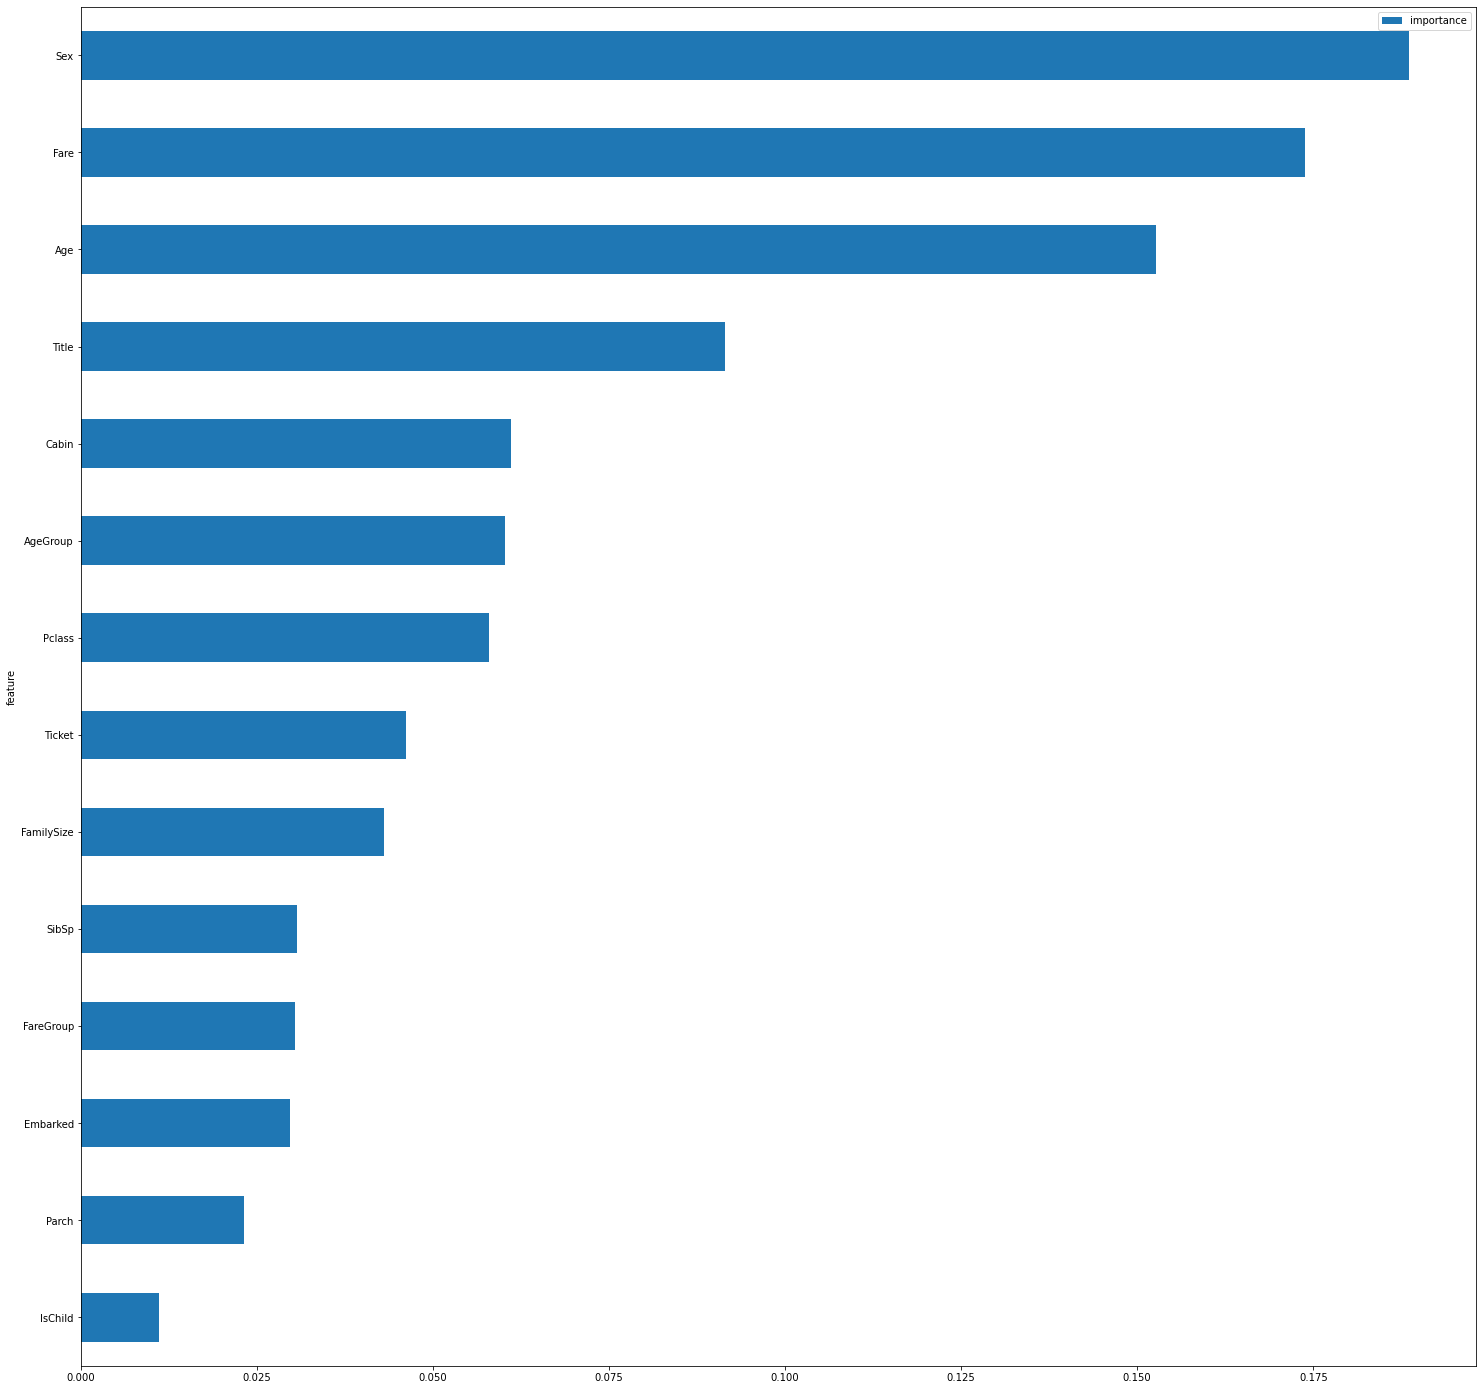

In [84]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

# Ewentualne zmiany (np. usuwanie kolumn)

In [85]:
combined.drop("SibSp", axis=1, inplace=True)
combined.drop("Parch", axis=1, inplace=True)

In [86]:
# combined.drop("Ticket", axis=1, inplace=True)  # nie zmieniało wyniku
# combined.drop("AgeGroup", axis=1, inplace=True)

In [87]:
combined.drop("IsChild", axis=1, inplace=True)

In [88]:
# combined.drop("Age", axis=1, inplace=True)

In [89]:
# combined.drop("Fare", axis=1, inplace=True)

In [90]:
combined.drop("FareGroup", axis=1, inplace=True)

In [91]:
# combined.drop("Embarked", axis=1, inplace=True)

In [92]:
combined.head()

,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,AgeGroup,FamilySize
0,0.841916,1,-0.538470,-2.360169,-0.503579,0.517788,0.622279,0.112936,-0.338008,1.282478
1,-1.546098,0,0.655928,0.092683,0.734519,-1.927616,-1.834926,1.355233,0.375625,1.282478
2,0.841916,0,-0.239870,3.300259,-0.490527,0.517788,0.622279,-1.129361,-0.338008,-0.477232
3,-1.546098,0,0.431979,-0.095998,0.382941,-1.927616,0.622279,1.355233,0.375625,1.282478
4,0.841916,1,0.431979,-0.095998,-0.488110,0.517788,0.622279,0.112936,0.375625,-0.477232


# Statystyka

In [93]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

In [94]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

<AxesSubplot:ylabel='feature'>

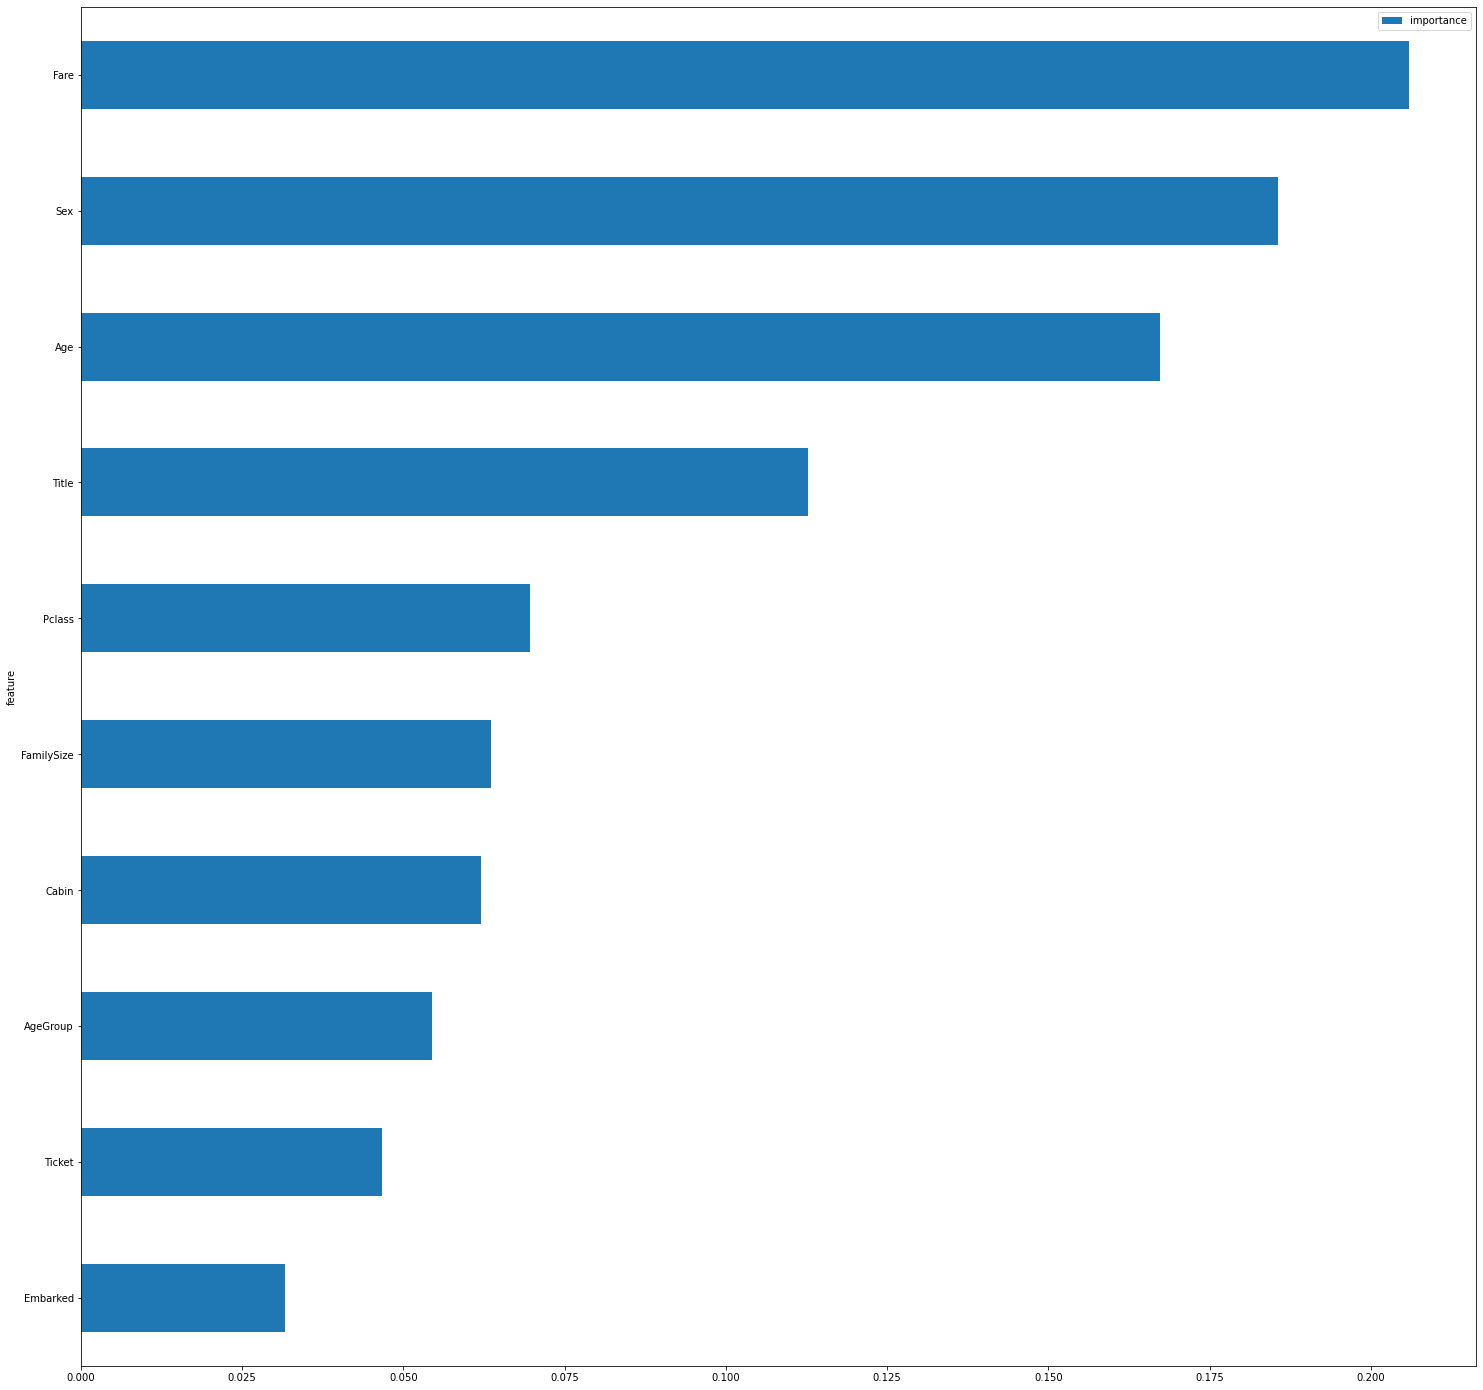

In [95]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

# **Model testowy lokalnie**

In [96]:
from sklearn.model_selection import train_test_split
local_train_x, local_test_x, local_train_y, local_test_y = train_test_split(combined.iloc[:891], train_y, test_size=0.20, random_state=42)

In [97]:
# local_train_x = combined.iloc[:714]
# local_train_y = train_y[:714]

# local_test_x = combined.iloc[714:891]
# local_test_y = train_y[714:891]

In [98]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

seed=123
kfold = StratifiedKFold(n_splits=5)

In [ ]:
pipe = Pipeline([
    ('classifier', SVC(kernel='rbf'))])


param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)

grid_1.fit(local_train_x, local_train_y)
grid_1.best_params_

In [100]:
pipe = Pipeline([
    ('classifier', SVC(kernel='poly'))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_2 = GridSearchCV(pipe, param_grid, cv=kfold)
grid_2.fit(local_train_x, local_train_y)
grid_2.best_params_

{'classifier__C': 10}

In [ ]:
pipe = Pipeline([
    ('classifier', SVC(kernel='linear'))])
param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}
grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)
grid_3.fit(local_train_x, local_train_y)
grid_3.best_params_

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000))])

param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C' : np.linspace(0, 1, 100),
            'classifier__solver':['newton-cg', 'lbfgs', 'liblinear'],
            # 'classifier__solver':['liblinear'],
            'classifier__penalty' : ['l1', 'l2']
}
grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10,scoring='accuracy')
grid_4.fit(local_train_x, local_train_y)
grid_4.best_params_

In [ ]:
import xgboost

xgb_cls = xgboost.XGBClassifier(n_estimators=10)

pipe = Pipeline([
    ('classifier', xgb_cls)])

param_grid = {
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.1, 1, 10],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__max_depth': [1,2, 3],
        'classifier__eta':[0.0001, 0.001, 0.01, 0.1],
#         'classifier__n_estimators':[1,2,5,10]
}
grid_5 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_5.fit(local_train_x, local_train_y)
grid_5.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
pipe = Pipeline([
    ('classifier', forest)])
param_grid = {
                 'classifier__max_depth' : [4, 6, 8],
                 'classifier__n_estimators': [50, 10],
                 'classifier__max_features': ['sqrt', 'auto', 'log2'],
                 'classifier__min_samples_split': [2, 3, 10],
                 'classifier__min_samples_leaf': [1, 3, 10],
                 'classifier__bootstrap': [True, False],
                 }

grid_6 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_6.fit(local_train_x, local_train_y)
grid_6.best_params_

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()

pipe = Pipeline([
    ('classifier', dec_tree)])

param_grid = {'classifier__criterion':['gini','entropy', 'log_loss'],
              'classifier__splitter':['best', 'random'],
              'classifier__max_depth':[1,10,100, 1000, 10000],
              'classifier__min_samples_split':[1,2,5,10, 50],
              'classifier__max_features':['auto', 'sqrt', 'log2'],
              'classifier__min_samples_leaf':[1,2,5,10,100]
             }

grid_7 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_7.fit(local_train_x, local_train_y)
grid_7.best_params_

In [ ]:
# https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1e-5, max_iter=1000,random_state=1)

pipe = Pipeline([
    ('classifier', mlp)])

param_grid = {'classifier__solver':['lbfgs', 'sgd', 'adam'],
              'classifier__activation':['identity', 'logistic', 'tanh', 'relu'],
              'classifier__hidden_layer_sizes':[(5,3), (100, 20)],
              'classifier__learning_rate':['constant', 'invscaling', 'adaptive'],
             }

grid_8 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_8.fit(local_train_x, local_train_y)
grid_8.best_params_

# **Wyniki lokalnie**

In [107]:
from sklearn import  metrics


models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('SVM poly', grid_2.best_estimator_))
models.append(('SVM linear', grid_3.best_estimator_))
models.append(('Logistic regression', grid_4.best_estimator_))
models.append(('xgboost', grid_5.best_estimator_))
models.append(('Random forest', grid_6))
models.append(('decision tree', grid_7))
models.append(('MLP', grid_8))





precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(local_test_y, model.predict(local_test_x)) ))
    print("recall_score: {}".format( metrics.recall_score(local_test_y, model.predict(local_test_x)) ))
    print("f1_score: {}".format( metrics.f1_score(local_test_y, model.predict(local_test_x)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(local_test_y, model.predict(local_test_x)) ))
    precision_score.append(metrics.precision_score(local_test_y, model.predict(local_test_x)))
    recall_score.append(metrics.recall_score(local_test_y, model.predict(local_test_x)))
    f1_score.append( metrics.f1_score(local_test_y, model.predict(local_test_x)))
    accuracy_score.append(metrics.accuracy_score(local_test_y, model.predict(local_test_x)))

SVM rbf
precision_score: 0.8235294117647058
recall_score: 0.7567567567567568
f1_score: 0.7887323943661971
accuracy_score: 0.8324022346368715
SVM poly
precision_score: 0.7671232876712328
recall_score: 0.7567567567567568
f1_score: 0.761904761904762
accuracy_score: 0.8044692737430168
SVM linear
precision_score: 0.7536231884057971
recall_score: 0.7027027027027027
f1_score: 0.7272727272727273
accuracy_score: 0.7821229050279329
Logistic regression
precision_score: 0.8059701492537313
recall_score: 0.7297297297297297
f1_score: 0.7659574468085106
accuracy_score: 0.8156424581005587
xgboost
precision_score: 0.8059701492537313
recall_score: 0.7297297297297297
f1_score: 0.7659574468085106
accuracy_score: 0.8156424581005587
Random forest
precision_score: 0.835820895522388
recall_score: 0.7567567567567568
f1_score: 0.7943262411347517
accuracy_score: 0.8379888268156425
decision tree
precision_score: 0.8059701492537313
recall_score: 0.7297297297297297
f1_score: 0.7659574468085106
accuracy_score: 0.8156

In [108]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','SVM poly','SVM linear','Logistic Regression', 'xgboost', 
                                        'Random forest','decision tree', 'MLP' ])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM rbf,0.823529,0.756757,0.788732,0.832402
1,SVM poly,0.767123,0.756757,0.761905,0.804469
2,SVM linear,0.753623,0.702703,0.727273,0.782123
3,Logistic Regression,0.805970,0.729730,0.765957,0.815642
4,xgboost,0.805970,0.729730,0.765957,0.815642
5,Random forest,0.835821,0.756757,0.794326,0.837989
6,decision tree,0.805970,0.729730,0.765957,0.815642
7,MLP,0.835821,0.756757,0.794326,0.837989


# Przygotowywanie modelu do predykcji na kaggle

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

seed=123
kfold = StratifiedKFold(n_splits=5)

In [ ]:
pipe = Pipeline([
    ('classifier', SVC(kernel='linear'))])
param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}
grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_3.fit(combined.iloc[:891], train_y)
grid_3.best_params_

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000))])

param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__C' : np.linspace(0, 1, 100),
            'classifier__solver':['newton-cg', 'lbfgs', 'liblinear'],
            # 'classifier__solver':['liblinear'],
            'classifier__penalty' : ['l1', 'l2']
}
grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10,scoring='accuracy')
grid_4.fit(combined.iloc[:891], train_y)
# grid_4.fit(train, targets)
grid_4.best_params_

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
pipe = Pipeline([
    ('classifier', forest)])
param_grid = {
                 'classifier__max_depth' : [4, 6, 8],
                 'classifier__n_estimators': [50, 10],
                 'classifier__max_features': ['sqrt', 'auto', 'log2'],
                 'classifier__min_samples_split': [2, 3, 10],
                 'classifier__min_samples_leaf': [1, 3, 10],
                 'classifier__bootstrap': [True, False],
                 }
grid_6 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_6.fit(train, targets)
grid_6.best_params_


xgboost

In [ ]:
import xgboost

xgb_cls = xgboost.XGBClassifier()

pipe = Pipeline([
    ('classifier', xgb_cls)])

param_grid = {
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.1, 1, 10],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__max_depth': [1,2, 3],
        'classifier__eta':[0.0001, 0.001, 0.01, 0.1],
        'classifier__n_estimators':[1,2,5,10]
}
grid_5 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_5.fit(combined.iloc[:891], train_y)
grid_5.best_params_

decision tree classifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()

pipe = Pipeline([
    ('classifier', dec_tree)])

param_grid = {'classifier__criterion':['gini','entropy', 'log_loss'],
              'classifier__splitter':['best', 'random'],
              'classifier__max_depth':[1,10,100, 1000, 10000],
              'classifier__min_samples_split':[1,2,5,10, 50],
              'classifier__max_features':['auto', 'sqrt', 'log2'],
              'classifier__min_samples_leaf':[1,2,5,10,100]
             }

grid_7 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_7.fit(combined.iloc[:891], train_y)
grid_7.best_params_




Multi Layer Perceptron

In [109]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1e-5, max_iter=1000,random_state=1)

pipe = Pipeline([
    ('classifier', mlp)])

# najlepsze parametry jakie udało mi się uzyskać
param_grid = {'classifier__solver':['adam'],
              'classifier__activation':['logistic'],
              'classifier__hidden_layer_sizes':[(50,100, 50)],
              'classifier__learning_rate':['constant'],
             }

grid_8 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10, scoring='accuracy')
grid_8.fit(combined.iloc[:891], train_y)
grid_8.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__learning_rate=constant, classifier__solver=adam
[CV 1/5; 1/1] END classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__learning_rate=constant, classifier__solver=adam; total time=   1.0s
[CV 2/5; 1/1] START classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__learning_rate=constant, classifier__solver=adam
[CV 2/5; 1/1] END classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__learning_rate=constant, classifier__solver=adam; total time=   5.8s
[CV 3/5; 1/1] START classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__learning_rate=constant, classifier__solver=adam
[CV 3/5; 1/1] END classifier__activation=logistic, classifier__hidden_layer_sizes=(50, 100, 50), classifier__l

{'classifier__activation': 'logistic',
 'classifier__hidden_layer_sizes': (50, 100, 50),
 'classifier__learning_rate': 'constant',
 'classifier__solver': 'adam'}

In [ ]:
pipe = Pipeline([
    ('classifier', SVC(kernel='rbf'))])


param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, verbose=10)

grid_1.fit(combined.iloc[:891], train_y)
grid_1.best_params_

In [ ]:
pipe = Pipeline([
    ('classifier', SVC(kernel='poly'))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_2 = GridSearchCV(pipe, param_grid, cv=kfold)
grid_2.fit(combined.iloc[:891], train_y)
grid_2.best_params_

# Tworzenie pliku na kaggle

In [110]:
d = {'PassengerId': test_data["PassengerId"], 
    }
df = pd.DataFrame(data=d)
df.insert(loc=1, column='Survived', value=grid_8.best_estimator_.predict(combined.iloc[891:]))
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [111]:
df.to_csv("output.csv", index=False)